# Optimization Homework 1

# Semisupervised classification problem: analysis with Gradient Descent and BCGD algorithms

Authors: 
Omid Airom,
Mehran Farajinegarestan,
Nazli Hanifi,
Laura Legrottaglie

Objective:

Compare the performance of Gradient Descent and Block Coordinate Gradient Descent approaches to minimize the loss function of some semisupervised classification problems

In [220]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from matplotlib.lines import Line2D
from time import process_time
import scipy
import pandas as pd
from sklearn.utils import shuffle 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

### Synthetic dataset

In [221]:
#Generating a syntethic data set "moon-shaped" 
def make_moons(n_samples=10000, noise_sd=None, random_state=None):

    if isinstance(n_samples, int):
        samples_class1 = int(n_samples / 2)
        samples_class2 = n_samples - samples_class1
    else:
        try:
            samples_class1, samples_class2 = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e
            
    #x1 of class purple # from -1 to 1
    x1_class1 = np.cos(np.linspace(0, np.pi, samples_class1))
    #x2 of class purple # from 0 to 1 to 0
    x2_class1 = np.sin(np.linspace(0, np.pi, samples_class1))
    #x1 of class yellow # from 0 to 2             
    x1_class2 = 1 - np.cos(np.linspace(0, np.pi, samples_class2))
    #x2 of class yellow # from -1 to 0          
    x2_class2 = - np.sin(np.linspace(0, np.pi, samples_class2))            

    X = np.vstack([np.append(x1_class1, x1_class2), np.append(x2_class1, x2_class2)]).T
    y = np.hstack((-np.ones(samples_class1, dtype=np.intp), np.ones(samples_class2, dtype=np.intp)))
    y = np.reshape(y,(-1,1))
    
    #Adding noise
    if noise_sd is not None:
        np.random.seed(random_state)
        X += np.random.normal(0, noise_sd, X.shape)
        
    """Splitting the data in labeled and unlabeled in a stratified manner and 
    where the number of labeled points is 1%"""
    x_unlabeled, x_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=0.01, 
                                                                      stratify=y,random_state=41)
    
    
    return x_labeled, x_unlabeled, y_labeled, y_unlabeled

### Euclidean distance

In [222]:
def euclidean_distance(x,y, squared=True):
    x = x[:, None, :]
    y = y[None, :,:]
    dis = np.linalg.norm(x-y, ord=2, axis= -1) # using numpy broadcasting
    if squared:
        return np.power(dis,2)
    return dis

### Similarity function
We define the similarity function as follows
$$ w(x,y) = {e^{-a\sum_{i=1}^k (x_i-y_i)^2 }}$$

where $i$ and $j$ are respectively the index of the label and unlabeled data.
Therefore when $k=2$ we have

* <font size="0.5"> **matrix of the weights between labeled and unlabeled points**
    
$$\omega_{ij}={e^{-a[(x_{1i}-x_{1j})^2+(x_{2i}-x_{2j})^2]}}$$
    
* <font size="0.5"> **matrix of the weights between unlabeled and unlabeled points** 

    
\begin{equation} if \quad\  k=j  \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad \omega_{jj}=1 \end{equation}
 \begin{equation} if \quad\  k\neq j \quad\quad\quad \omega_{kj}={e^{-a[(x_{1k}-x_{1j})^2+(x_{2k}-x_{2j})^2]}}  \end{equation}


In [223]:
"""Defining the weights matrix using gaussian similarity 
function with hyperparameter a=50"""
def simirality_weights(x_labeled,x_unlabeled, a=50):
    weights_l_u = np.exp(-a*euclidean_distance(x_labeled,x_unlabeled))
    weights_u_u = np.exp(-a*euclidean_distance(x_unlabeled,x_unlabeled))
    return weights_l_u,weights_u_u

### Cost function
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$

$y$ : predicted class

$\bar{y}$ : class of label points

$\omega_{ij}$ : similarity weights matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity weights matrix between unlabeled data

$u$ : unlabeled data

$l$ : labeled data

In [224]:
#Defining the cost function we want to minimize 
def fy(y_unlabeled,y_labeled, weights_l_u, weights_u_u):
    tot1 = np.sum(weights_l_u.T * (y_unlabeled[:, np.newaxis] - y_labeled) ** 2)
    tot2 = np.sum(weights_u_u * (y_unlabeled[:, np.newaxis] - y_unlabeled) ** 2)
    return tot1 + tot2/2

### Gradient
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + 2\sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2  \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$
We set 
\begin{equation} c_1 = 2  \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij}
\quad\quad c_2 = 2\sum_{i=0}^lw_{ij} \quad\quad c_3= \sum_{i=0}^u\bar{w}_{ij} \end{equation}
where
$\sum_{i=0}^u\bar{w}_{ij}$ represents the $j^{th}$ column of the similarity measure matrix between unlabeled and unlabeled data points since $\bar{w}_{ij}=\bar{w}_{ji}$ 

and
$\sum_{i=0}^l{w}_{ij}$ represents the $i^{th}$ row of the similarity measure matrix between labeled and unlabeled data points

In [225]:
def cal_c1_c2(weights_l_u, weights_u_u, y_labeled):
    c1=2*(np.sum(weights_l_u,axis=0))+ np.sum(weights_u_u,axis=0)
    """Since we are summing along the columns and weights_u_u is a 
    symmetric matrix, we don't need to double the second sum"""
    c2= 2*(weights_l_u*(y_labeled).reshape((-1,1))).sum(0)
    return c1, c2

def gradient(y_u, weights_u_u):
    c3 = ((weights_u_u*y_u.reshape((-1,1))).sum(0)).reshape(-1,)
    return c1 * y_u -c2 -c3


### Hessian and step size
$$ Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + 2(\sum_{i=0}^u\bar{w}_{i1}) - 2\bar{w}_{11} & -2\bar{w}_{12} & \cdots & -2\bar{w}_{1n}\\
    -2\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (2\sum_{i=0}^u\bar{w}_{i2}) - 2\bar{w}_{22} & \cdots & -2\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -2\bar{w}_{n1} & -2\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (2\sum_{i=0}^u\bar{w}_{in}) - 2\bar{w}_{nn}\\
  \end{array} } \right]
  $$

In [226]:
def c_hessian(weights_l_u,weights_u_u, y_unlabeled):
    hessian= -weights_u_u.copy()
    for i in range(len(y_unlabeled)):
        hessian[i,i]=2*np.sum(weights_l_u[:,i]) + np.sum(weights_u_u[:,i]) - weights_u_u[i,i]
    return hessian

In [227]:
"""Computing the eigenvalues of the Hessian matrix to determine the Lipschitz 
constant L and the fixed step size 1/L"""
def cal_alpha(hessian):
    eigenvalues = scipy.linalg.eigvalsh(hessian)
    L = max(eigenvalues)
    alpha= 1/L
    print(alpha)
    return alpha

### Inizialization of the points

In [228]:
"""flag=True for plots related to the accuracy, flag=False for the plots
related to the cost function"""

def initialize_points(flag):
  np.random.seed(41)
  if flag==True:
    y_u_initial = np.random.choice([-1, 1], size=(len(x_unlabeled),)).astype("float64")
  else:
    y_u_initial = np.zeros(len(y_unlabeled)).astype("float64")
  return y_u_initial

### Accuracy 

In [229]:
def accuracy(y_u, y_unlabeled):
  y_a = y_u.copy()
  threshold=0
  y_a[y_a<threshold]=-1
  y_a[y_a>threshold]=1
  return sum(y_a==y_unlabeled)/len(y_unlabeled)

### Gradient descent and Block Coordinate Gradient Descent 
**Variables and constants**
- `eps`: threshold of $||\nabla f(y)||$ to check as stopping condition
- `max_iter`: max number of iterations 
- `f`: vector that contains the values of the loss function
- `times`: vector that contains the values of the CPU time
- `acc`: vector that contains the values of the accuracy

In [230]:
def GS(y_u,y_l,y_unlabeled, weights_l_u, weights_u_u, alpha):
    eps = 1.0e-4
    max_iter= 100
    times=[0]
    f=[fy(y_u,y_l,weights_l_u,weights_u_u)]
    acc=[accuracy(y_u,y_unlabeled)]
    g = gradient(y_u,weights_u_u)

    time_start= process_time()
    
    for it in range(1,max_iter+1):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        y_u= y_u - alpha*g
        f_it=fy(y_u,y_l,weights_l_u,weights_u_u)
        f.append(f_it)
        acc.append(accuracy(y_u,y_unlabeled))
        g = gradient(y_u,weights_u_u)
        times.append(process_time() - time_start)

         
    return y_u,f,times,acc,check_stop

### Randomized Block Coordinate Gradient Descent

**Variables**
- `replacement`: boolean value that allows to choose between random permutation of the indexes (False) or random sampling (True)
- `indexes`: vector containing the random indexes


In [231]:
def choice_randomized(replacement):
  np.random.seed(41)
  num_it = 100
  indexes = np.array([])
  for i in range(num_it+1):
    indexes_k = np.random.choice(len(y_unlabeled), len(y_unlabeled),replace=replacement)
    indexes = np.concatenate((indexes,indexes_k))
  return indexes.astype(int)

In [232]:
def BCGD_Randomized(y_u, y_l,indexes):
    eps = 1.0e-4
    max_iter = 100 * len(y_u)
    times = [0]
    f = [fy(y_u,y_l, weights_l_u, weights_u_u)]
    g = gradient(y_u, weights_u_u)
    alphas= np.full(max_iter,alpha)
    acc=[accuracy(y_u, y_unlabeled)]

    time_start = process_time()

    for it in range(1,max_iter+1):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        index = indexes[it]
        d = -g[index]
        y_u[index] += alphas[index] * d
        step = alphas[index]*g[index]
        g += weights_u_u[index]*step
        g[index] -= c1[index]*step
        i = it % len(y_u)
        if i == 0:
            f_it = fy(y_u,y_l, weights_l_u, weights_u_u)
            f.append(f_it)
            acc.append(accuracy(y_u, y_unlabeled))
            times.append(process_time() - time_start)
            #print(it / len(y_u))
            #print(f_it)

    return y_u, f, times, acc,check_stop

###  Block Coordinate Gradient Descent with Gauss-Southwell

In [233]:
def BCGD_GS(y_u, y_l):
    eps = 1.0e-4
    max_iter = 100 * len(y_u)
    times = [0]
    f = [fy(y_u, y_l, weights_l_u, weights_u_u)]
    g = gradient(y_u, weights_u_u)
    acc=[accuracy(y_u, y_unlabeled)]

    time_start = process_time()

    for it in range(1,max_iter+1):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        index = np.argmax(np.abs(g))
        d = -g[index]
        y_u[index] += alpha * d
        step = alpha*g[index]
        g += weights_u_u[index]*step
        g[index] -= c1[index]*step
        i = it % len(y_u)
        if i == 0:
            f_it = fy(y_u, y_l, weights_l_u, weights_u_u)
            f.append(f_it)
            acc.append(accuracy(y_u, y_unlabeled))
            times.append(process_time() - time_start)
            #print(it / len(y_u))
            #print(f_it)

    return y_u, f, times, acc, check_stop

### Synthetic moon-shaped dataset: running the three algorithms

In [234]:
x_labeled, x_unlabeled, y_labeled, y_unlabeled = make_moons(n_samples=10000, noise_sd= 0.15, random_state=41)

y_unlabeled = y_unlabeled[:,0]
y_labeled = y_labeled[:,0]

print("The number of labeled data point is: ", x_labeled.shape[0])
print("The number of unlabeled data point is: ", x_unlabeled.shape[0])

The number of labeled data point is:  100
The number of unlabeled data point is:  9900


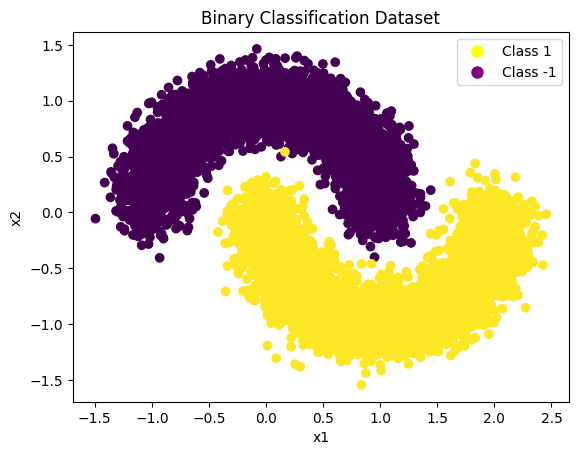

In [235]:
# Create a scatter plot of the data
def plot_xy(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y)
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title('Binary Classification Dataset')
  legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10)]
  plt.legend(handles=legend_elements, loc='upper right')
  plt.show()
plot_xy(x_unlabeled,y_unlabeled)

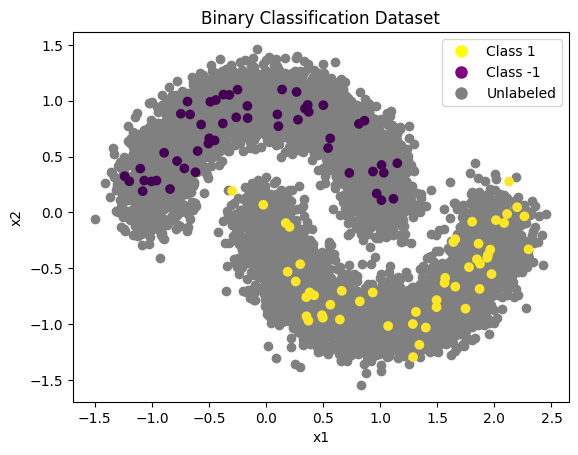

In [236]:
#Scatter plot of the labeled and unlabeled data
plt.scatter(x_unlabeled[:,0],x_unlabeled[:,1],c="gray")
plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Binary Classification Dataset')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Unlabeled', markerfacecolor='gray', markersize=10)
                   ]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

In [237]:
weights_l_u,weights_u_u = simirality_weights(x_labeled,x_unlabeled)

In [238]:
c1, c2 = cal_c1_c2(weights_l_u, weights_u_u, y_labeled)

In [239]:
hessian = c_hessian(weights_l_u,weights_u_u, y_unlabeled)

In [240]:
alpha = cal_alpha(hessian)

0.004135429026980374


In [241]:
y_u_init = initialize_points(False)
y_u_init_rm = y_u_init.copy()
y_u_init_perm = y_u_init.copy()
y_u_init_GS = y_u_init.copy()

### Gradient descent

In [242]:
y_u_final,f_gd,times_gd,acc_gd,gnr = GS(y_u_init,y_labeled,y_unlabeled, weights_l_u, weights_u_u, alpha)

In [243]:
print("The final accuracy is ",acc_gd[-1])

The final accuracy is  0.9997979797979798


### Scatter plot with predicted values

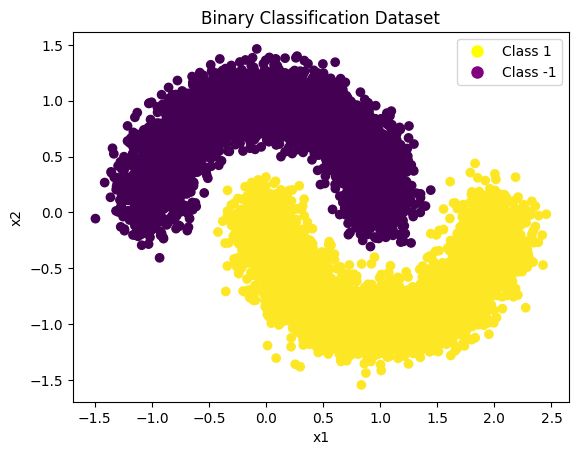

In [244]:
threshold=0
y_u_final[y_u_final<threshold]=-1
y_u_final[y_u_final>threshold]=1

X_u_final = np.hstack((x_unlabeled[:,:2],y_u_final.reshape((-1,1))))

_ = plt.scatter(X_u_final[:,0],X_u_final[:,1],c=X_u_final[:,2])
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Binary Classification Dataset')
plt.show()

In [245]:
y_u_init2 = initialize_points(True)
y_u_init_rm2 = y_u_init2.copy()
y_u_init_perm2 = y_u_init2.copy()
y_u_init_GS2 = y_u_init2.copy()

In [246]:
y_u_final,f_a,times_a,acc_gd,gnr = GS(y_u_init2,y_labeled, y_unlabeled, weights_l_u, weights_u_u, alpha)

### Gradient descent graphs

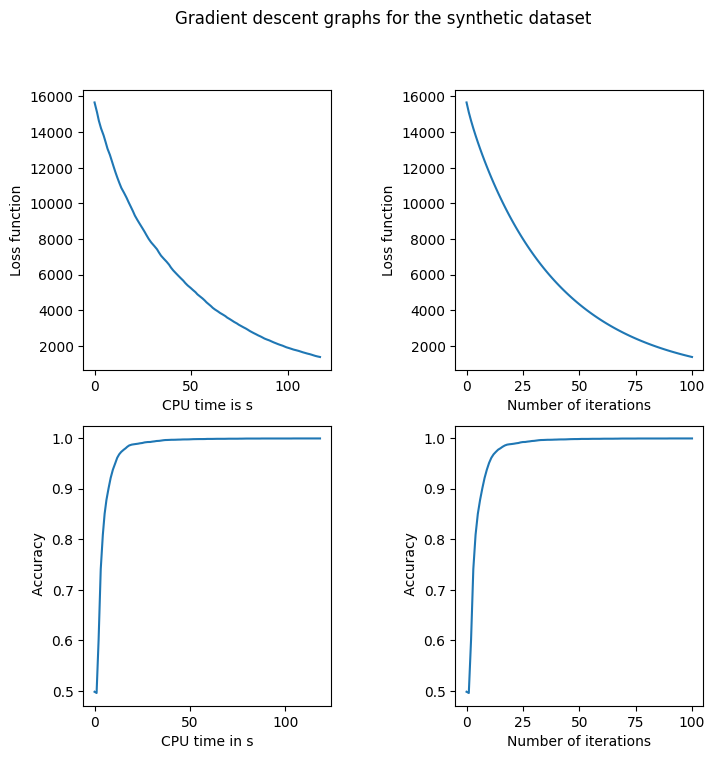

In [247]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gd,f_gd)
axs[0,1].plot(np.arange(0,101),f_gd)
axs[1,0].plot(times_a,acc_gd)
axs[1,1].plot(np.arange(0,101),acc_gd)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gradient descent graphs for the synthetic dataset')
plt.show()

### Randomized BCGD

In [248]:
indexes_rmsample = choice_randomized(True)
indexes_perm = choice_randomized(False)

In [249]:
y_u_final,f_r,times_r,acc_r,check_stop=BCGD_Randomized(y_u_init_rm,y_labeled,indexes_rmsample)

In [250]:
y_u_final,f_perm,times_perm,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm,y_labeled,indexes_perm)

In [251]:
y_u_final,f_r_a,times_r_a,acc_r,check_stop=BCGD_Randomized(y_u_init_rm2,y_labeled,indexes_rmsample)

In [252]:
y_u_final,f_perm_a,times_perm_a,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm2,y_labeled,indexes_perm)

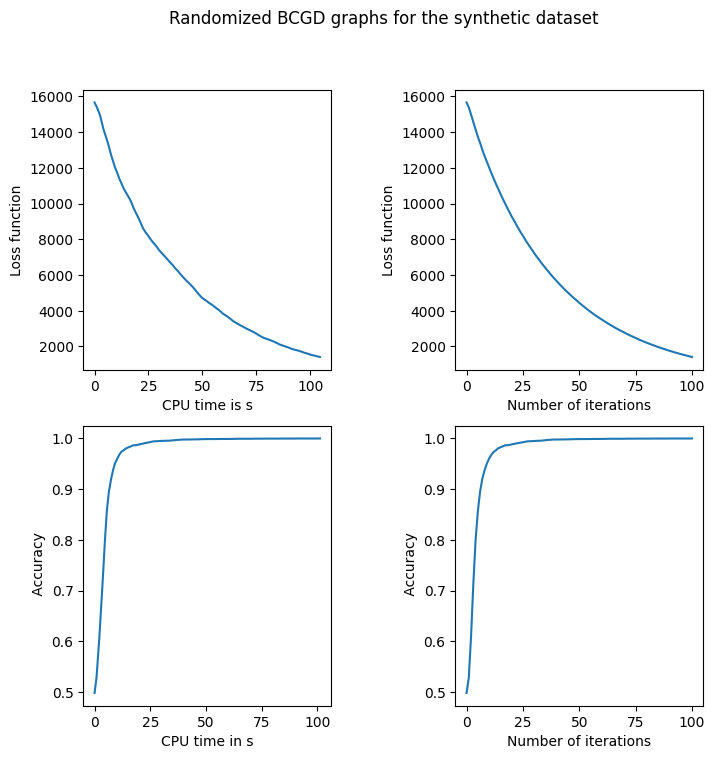

In [253]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_r,f_r)
axs[0,1].plot(np.arange(0,101),f_r)
axs[1,0].plot(times_r_a,acc_r)
axs[1,1].plot(np.arange(0,101),acc_r)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')


axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Randomized BCGD graphs for the synthetic dataset')
plt.show()

### Gauss-Southwell BCGD

In [254]:
y_u_final,f_gs,times_gs,acc_gs,check_stop=BCGD_GS(y_u_init_GS,y_labeled)

In [255]:
y_u_final,f_gs_a,times_gs_a,acc_gs,check_stop=BCGD_GS(y_u_init_GS2,y_labeled)

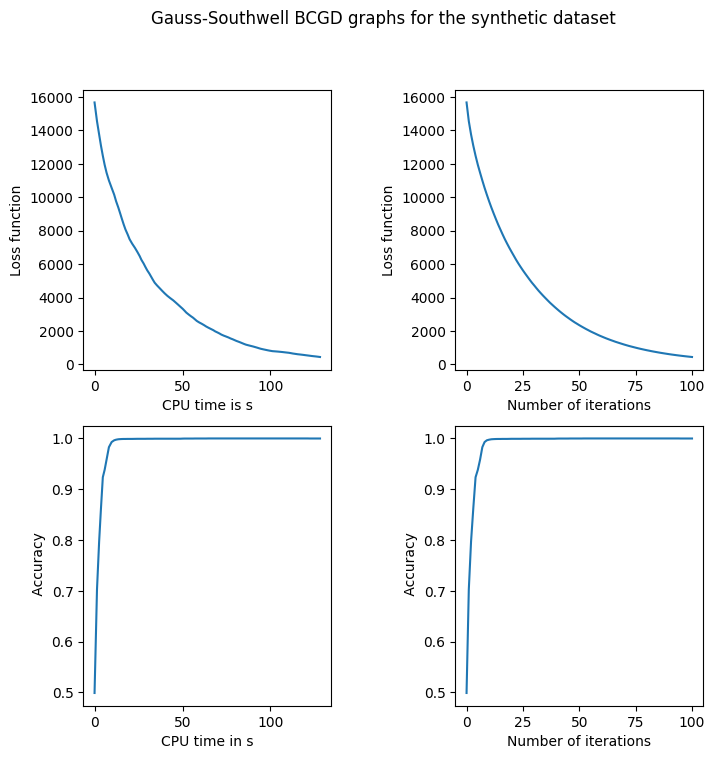

In [256]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gs,f_gs)
axs[0,1].plot(np.arange(0,101),f_gs)
axs[1,0].plot(times_gs,acc_gs)
axs[1,1].plot(np.arange(0,101),acc_gs)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gauss-Southwell BCGD graphs for the synthetic dataset')
plt.show()

### Comparison between the three algorithms

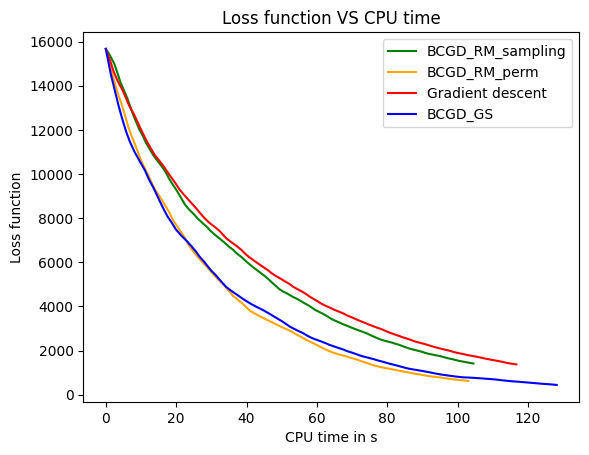

In [257]:
plt.plot(times_r,f_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm, f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_gd,f_gd,label="Gradient descent",color="red")
plt.plot(times_gs,f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel("Loss function")
plt.legend()
plt.show()

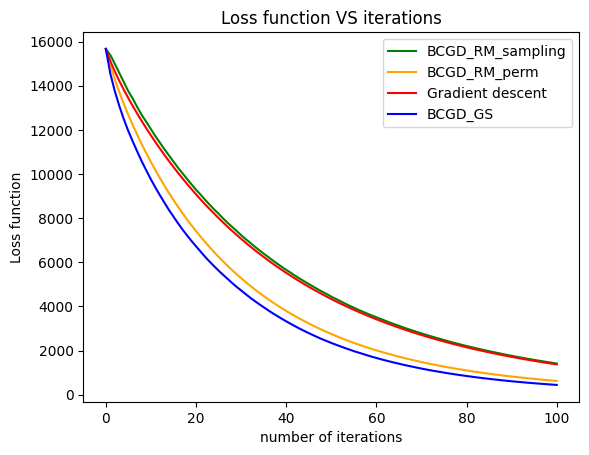

In [258]:
plt.plot(np.arange(0,101),f_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),f_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS iterations")
plt.xlabel("number of iterations")
plt.ylabel("Loss function")
plt.legend()
plt.show()

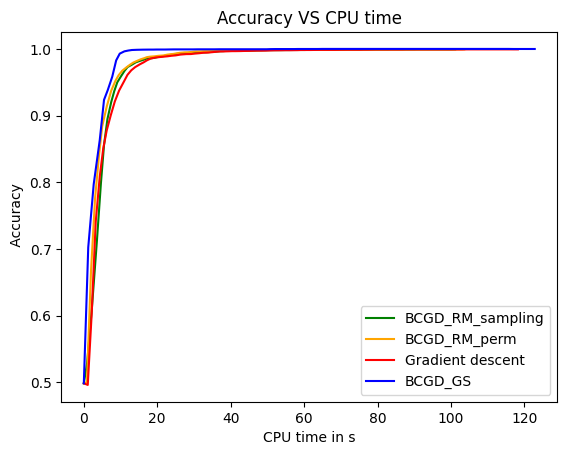

In [259]:
plt.plot(times_r_a,acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm_a, acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_a,acc_gd,label="Gradient descent",color="red")
plt.plot(times_gs_a,acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()

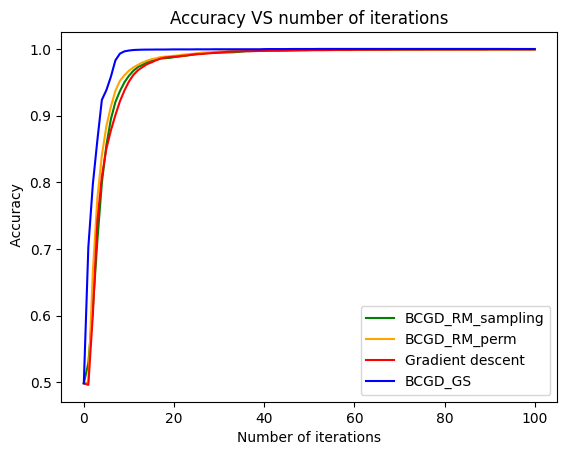

In [260]:
plt.plot(np.arange(0,101),acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),acc_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()

### 1 real data set: Smoker dataset
It's a binary classification problem which aims to predict if a person will have cancer or not using genes and its smoking history 

In [324]:
data = pd.read_csv("Smoker_dataset.csv")
data

,Gene2337,Gene35715,Gene12936,Gene1689,FGFR1,GATA4,type,Condition
0,-4.750470,-1.518091,6.715013,-1.722331,0.170110,-7.846961,Smoker,Cancer
1,-5.183375,0.039654,2.529460,-1.323490,-0.315844,-4.447406,Smoker,Cancer
2,1.579079,1.588153,0.569724,-1.229601,-4.119116,0.649277,Smoker,Normal
3,-1.557053,-3.818996,3.798518,-1.204911,1.010464,-6.712354,Smoker,Cancer
4,-1.329637,-3.623963,2.722249,-0.784387,1.564218,-5.580853,Smoker,Cancer
...,...,...,...,...,...,...,...,...
1018,7.703466,2.294580,2.789479,6.321373,-1.037499,7.665423,Smoker,Normal
1019,1.898735,3.909679,6.033432,7.616461,-0.808922,5.516971,Smoker,Normal
1020,3.049206,0.000000,2.874886,NaN,-1.930069,4.096234,Smoker,Normal
1021,4.849276,3.927777,3.702056,NaN,-1.430435,6.421559,Smoker,Normal


### Preprocessing

In [325]:
"""Removing the NaN values since their number is very small compared to the 
dimension of the dataset and encoding categorical variables"""
data.dropna(inplace=True)
data.type = data.type.map(lambda x: 1 if x=='Smoker' else -1)
data.Condition = data.Condition.map(lambda x: 1 if x=='Cancer' else -1)


In [326]:
#Feature selection based on mutual information and f_regression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import f_regression
X = data.values[:,:-1]
y = data.values[:,-1]
X_new = SelectKBest(score_func=f_regression, k=2).fit_transform(X,y)
X_new = SelectKBest(score_func=mutual_info_classif,k=2).fit_transform(X_new,y)

In [327]:
#Splitting the data in labeled and unlabeled in a stratified manner
def split_data(X,y):
  x_unlabeled, x_labeled, y_unlabeled, y_labeled = train_test_split(X_new, y, test_size=0.03, stratify=y,random_state=41)
  return x_unlabeled, x_labeled, y_unlabeled, y_labeled

In [328]:
x_unlabeled, x_labeled, y_unlabeled, y_labeled = split_data(X_new,y)

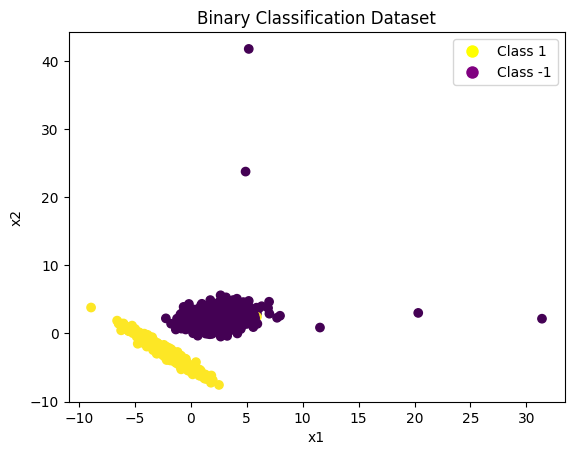

In [266]:
# Create a scatter plot of the data
def plot_xy(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y)
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title('Binary Classification Dataset')
  legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10)]
  plt.legend(handles=legend_elements, loc='upper right')
  plt.show()
plot_xy(x_unlabeled,y_unlabeled)

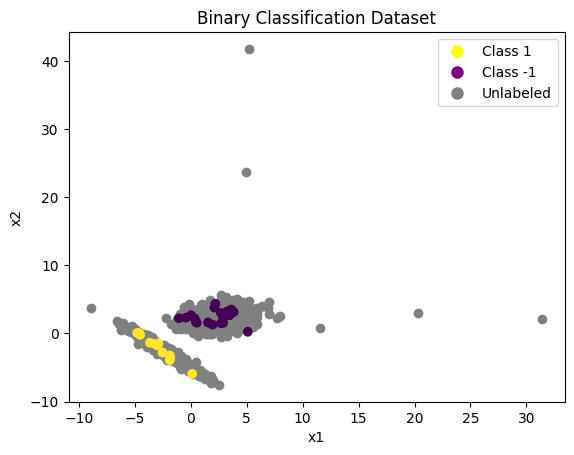

In [267]:
#Scatter plot of the labeled and unlabeled data
plt.scatter(x_unlabeled[:,0],x_unlabeled[:,1],c="gray")
plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Binary Classification Dataset')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Unlabeled', markerfacecolor='gray', markersize=10)
                   ]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

In [268]:
weights_l_u,weights_u_u = simirality_weights(x_labeled,x_unlabeled,a=1)

In [269]:
c1, c2 = cal_c1_c2(weights_l_u, weights_u_u, y_labeled)

In [270]:
hessian = c_hessian(weights_l_u,weights_u_u, y_unlabeled)

In [271]:
alpha = cal_alpha(hessian)

0.0069935371322030915


In [272]:
y_u_init = initialize_points(False)
y_u_init_rm = y_u_init.copy()
y_u_init_perm = y_u_init.copy()
y_u_init_GS = y_u_init.copy()

### Gradient descent

In [273]:
y_u_final,f_gd,times_gd,acc_gd,gnr = GS(y_u_init,y_labeled,y_unlabeled, weights_l_u, weights_u_u, alpha)

In [274]:
print("The final accuracy is ",acc_gd[-1])

The final accuracy is  0.9938837920489296


### Scatter plot with predicted values

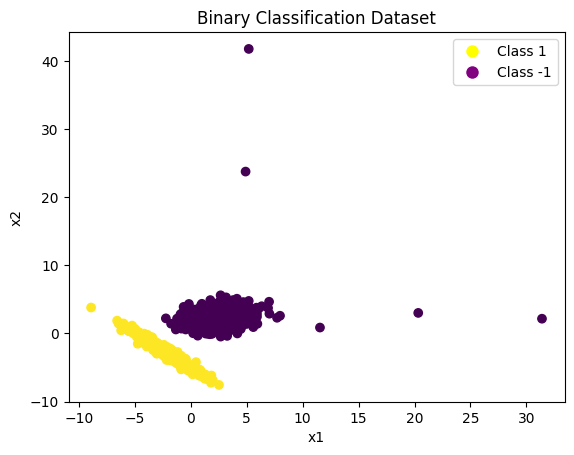

In [275]:
threshold=0
y_u_final[y_u_final<threshold]=-1
y_u_final[y_u_final>threshold]=1

X_u_final = np.hstack((x_unlabeled[:,:2],y_u_final.reshape((-1,1))))

_ = plt.scatter(X_u_final[:,0],X_u_final[:,1],c=X_u_final[:,2])
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Binary Classification Dataset')
plt.show()

In [276]:
y_u_init2 = initialize_points(True)
y_u_init_rm2 = y_u_init2.copy()
y_u_init_perm2 = y_u_init2.copy()
y_u_init_GS2 = y_u_init2.copy()

In [277]:
y_u_final,f_a,times_a,acc_gd,gnr = GS(y_u_init2,y_labeled, y_unlabeled, weights_l_u, weights_u_u, alpha)

### Gradient descent graphs

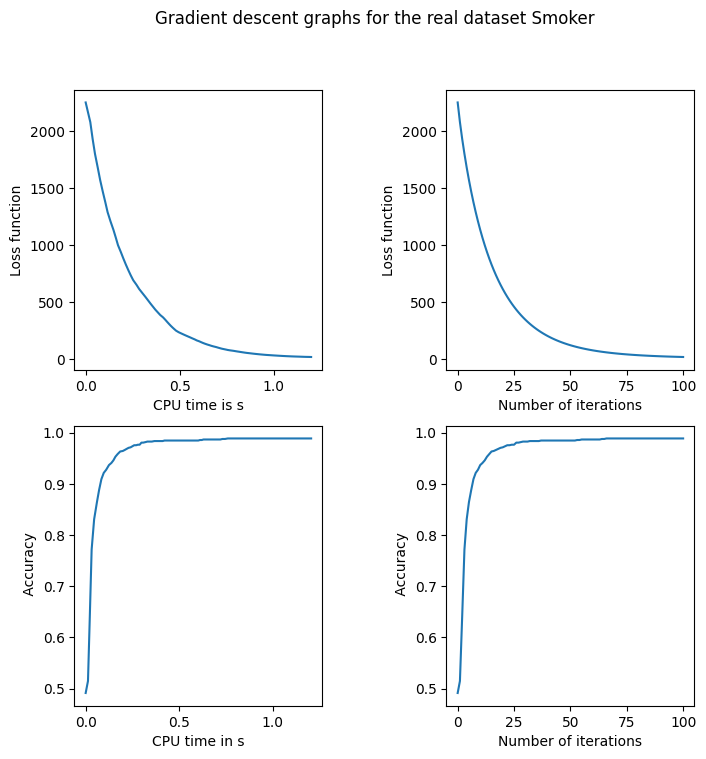

In [278]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gd,f_gd)
axs[0,1].plot(np.arange(0,101),f_gd)
axs[1,0].plot(times_a,acc_gd)
axs[1,1].plot(np.arange(0,101),acc_gd)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gradient descent graphs for the real dataset Smoker')
plt.show()

### Randomized BCGD

In [279]:
indexes_rmsample = choice_randomized(True)
indexes_perm = choice_randomized(False)

In [280]:
y_u_final,f_r,times_r,acc_r,check_stop=BCGD_Randomized(y_u_init_rm,y_labeled,indexes_rmsample)

In [281]:
y_u_final,f_perm,times_perm,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm,y_labeled,indexes_perm)

In [282]:
y_u_final,f_r_a,times_r_a,acc_r,check_stop=BCGD_Randomized(y_u_init_rm2,y_labeled,indexes_rmsample)

In [283]:
y_u_final,f_perm_a,times_perm_a,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm2,y_labeled,indexes_perm)

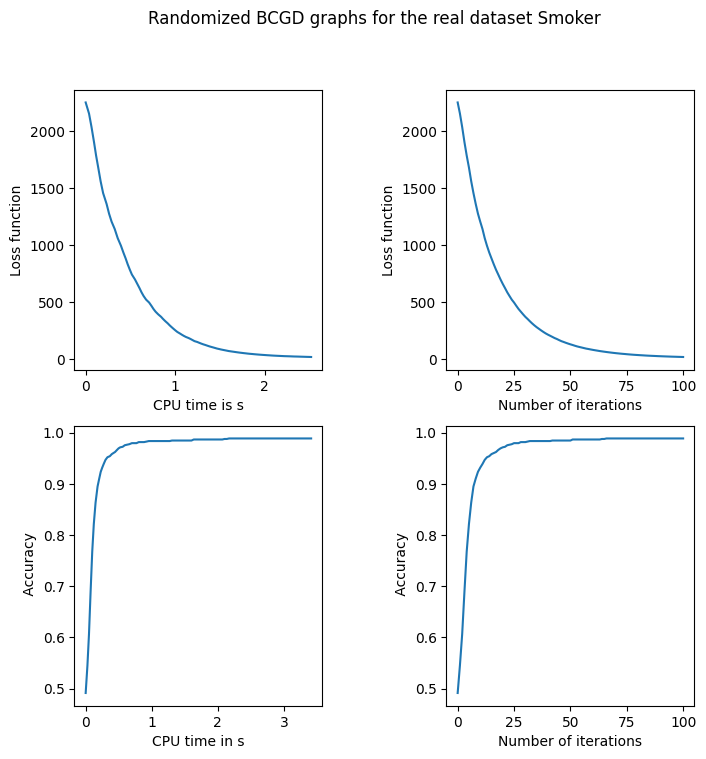

In [284]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_r,f_r)
axs[0,1].plot(np.arange(0,101),f_r)
axs[1,0].plot(times_r_a,acc_r)
axs[1,1].plot(np.arange(0,101),acc_r)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')


axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Randomized BCGD graphs for the real dataset Smoker')
plt.show()

### Gauss-Southwell BCGD

In [285]:
y_u_final,f_gs,times_gs,acc_gs,check_stop=BCGD_GS(y_u_init_GS,y_labeled)

In [286]:
y_u_final,f_gs_a,times_gs_a,acc_gs,check_stop=BCGD_GS(y_u_init_GS2,y_labeled)

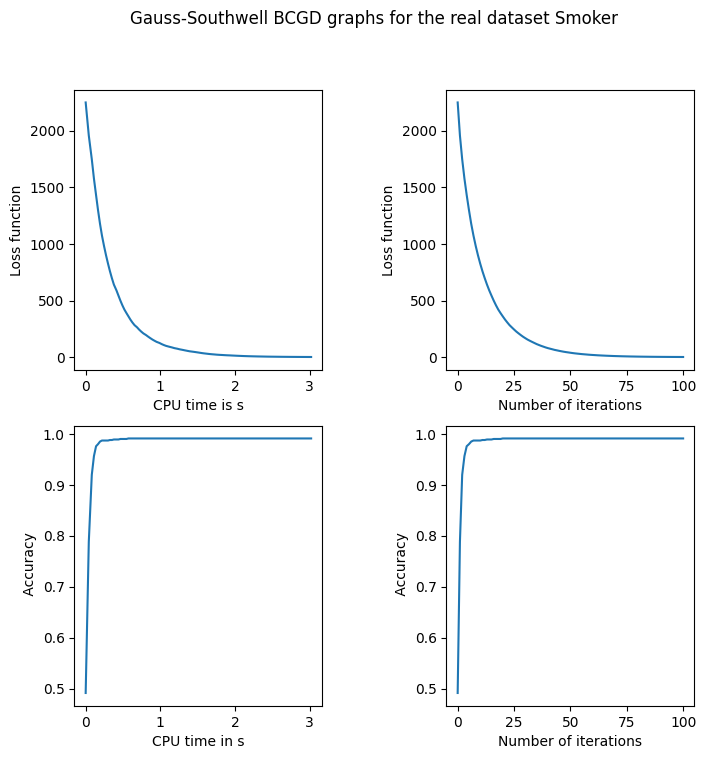

In [287]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gs,f_gs)
axs[0,1].plot(np.arange(0,101),f_gs)
axs[1,0].plot(times_gs,acc_gs)
axs[1,1].plot(np.arange(0,101),acc_gs)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gauss-Southwell BCGD graphs for the real dataset Smoker')
plt.show()

### Comparison between the three algorithms

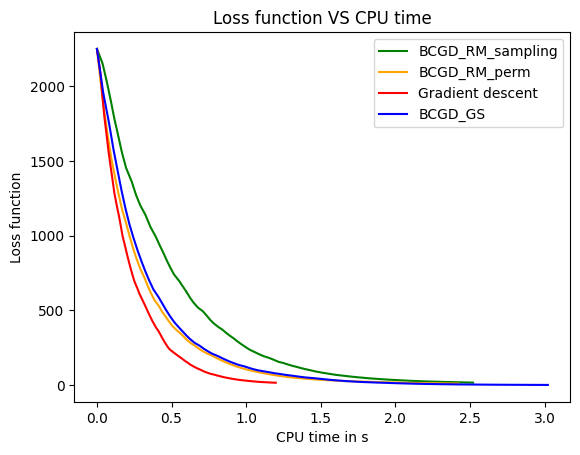

In [288]:
plt.plot(times_r,f_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm, f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_gd,f_gd,label="Gradient descent",color="red")
plt.plot(times_gs,f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel("Loss function")
plt.legend()
plt.show()

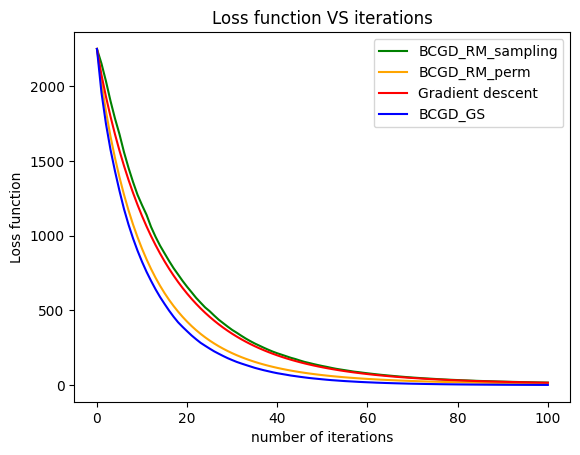

In [289]:
plt.plot(np.arange(0,101),f_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),f_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS iterations")
plt.xlabel("number of iterations")
plt.ylabel("Loss function")
plt.legend()
plt.show()

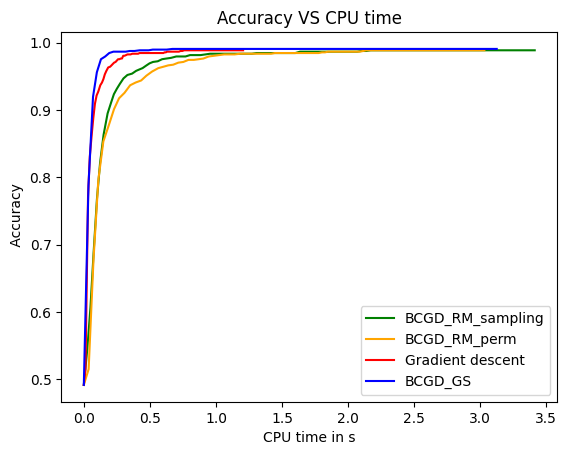

In [290]:
plt.plot(times_r_a,acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm_a, acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_a,acc_gd,label="Gradient descent",color="red")
plt.plot(times_gs_a,acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()

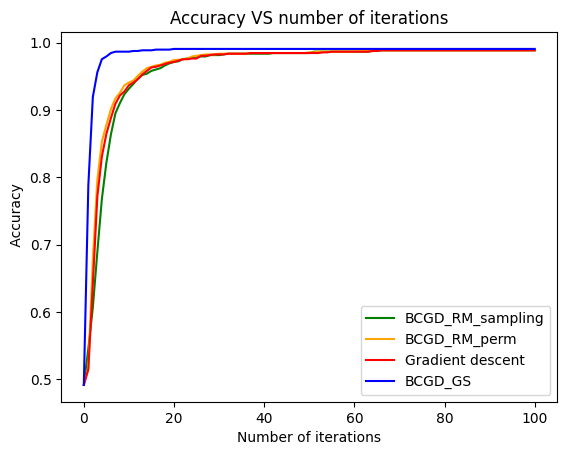

In [291]:
plt.plot(np.arange(0,101),acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),acc_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()

### 2 Real dataset: Housing prices
It's a binary classification problem that aims to determine if the price of a house is higher or below than the median

In [330]:
df = pd.read_csv('Housing.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1.0,273,21.0,391.99,9.67,22.4
505,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1.0,273,21.0,396.90,9.08,20.6
506,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1.0,273,21.0,396.90,5.64,23.9
507,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1.0,273,21.0,393.45,6.48,22.0


### Preprocessing

In [331]:
def remove_outlier(df, col_names):
    for col_name in col_names:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
        return df

In [332]:
def preprocessing_housing_ds(path='Housing.csv'):
    df = pd.read_csv(path)
    df.drop(columns=['ZN', 'INDUS', 'CHAS', 'RAD', 'TAX', 'B', 'LSTAT'], inplace=True)

    df = df.dropna()
    df = remove_outlier(df, ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO'])

    df_label = df['MEDV']
    df.drop(columns=['MEDV'], inplace=True)

    normalized_df=(df-df.min()) /(df.max()-df.min())

    df_label = df_label.map(lambda x: x < df_label.median()).map({True:1, False:-1})

    df = pd.concat([normalized_df, df_label], axis=1)
    # df = pd.concat([df, df_label], axis=1)
    df = shuffle(df)
    return df

In [333]:
df = preprocessing_housing_ds()

In [334]:
#Splitting the data into labeled and unlabeled points
x_labeled, x_unlabeled = df.iloc[:44,:-1].values, df.iloc[44:,:-1].values 
y_labeled, y_unlabeled = df.iloc[:44,-1].values, df.iloc[44:, -1].values

In [299]:
weights_l_u,weights_u_u = simirality_weights(x_labeled,x_unlabeled,a=200)

In [300]:
c1, c2 = cal_c1_c2(weights_l_u, weights_u_u, y_labeled)

In [301]:
hessian = c_hessian(weights_l_u,weights_u_u, y_unlabeled)

In [302]:
alpha = cal_alpha(hessian)

0.17630886206973956


In [303]:
y_u_init = initialize_points(False)
y_u_init_rm = y_u_init.copy()
y_u_init_perm = y_u_init.copy()
y_u_init_GS = y_u_init.copy()

### Gradient descent

In [304]:
y_u_final,f_gd,times_gd,acc_gd,gnr = GS(y_u_init,y_labeled,y_unlabeled, weights_l_u, weights_u_u, alpha)

In [305]:
print("The final accuracy is ",acc_gd[-1])

The final accuracy is  0.7455470737913485


In [307]:
y_u_init2 = initialize_points(True)
y_u_init_rm2 = y_u_init2.copy()
y_u_init_perm2 = y_u_init2.copy()
y_u_init_GS2 = y_u_init2.copy()

In [308]:
y_u_final,f_a,times_a,acc_gd,gnr = GS(y_u_init2,y_labeled, y_unlabeled, weights_l_u, weights_u_u, alpha)

### Gradient descent graphs

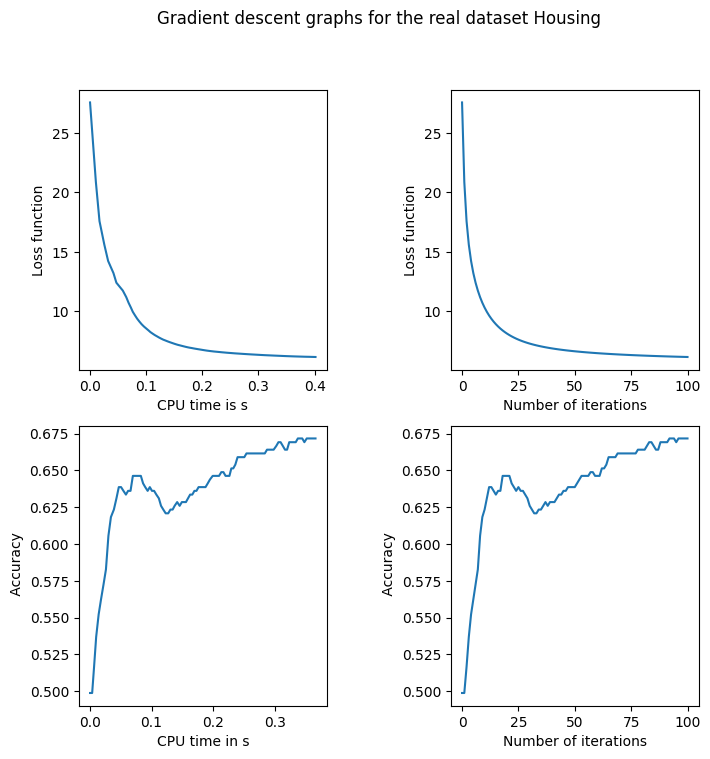

In [309]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gd,f_gd)
axs[0,1].plot(np.arange(0,101),f_gd)
axs[1,0].plot(times_a,acc_gd)
axs[1,1].plot(np.arange(0,101),acc_gd)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gradient descent graphs for the real dataset Housing')
plt.show()

### Randomized BCGD

In [310]:
indexes_rmsample = choice_randomized(True)
indexes_perm = choice_randomized(False)

In [311]:
y_u_final,f_r,times_r,acc_r,check_stop=BCGD_Randomized(y_u_init_rm,y_labeled,indexes_rmsample)

In [312]:
y_u_final,f_perm,times_perm,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm,y_labeled,indexes_perm)

In [313]:
y_u_final,f_r_a,times_r_a,acc_r,check_stop=BCGD_Randomized(y_u_init_rm2,y_labeled,indexes_rmsample)

In [314]:
y_u_final,f_perm_a,times_perm_a,acc_perm,check_stop = BCGD_Randomized(y_u_init_perm2,y_labeled,indexes_perm)

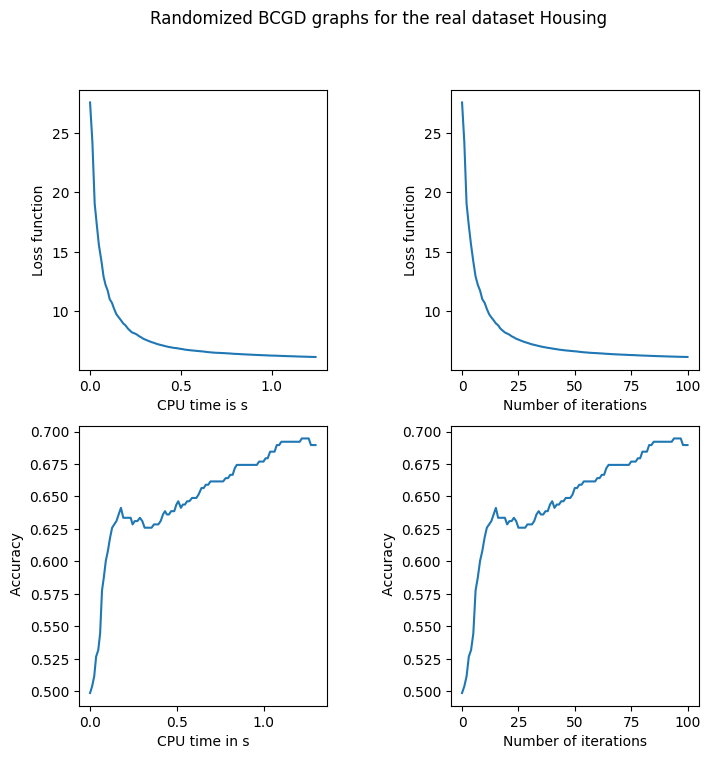

In [315]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_r,f_r)
axs[0,1].plot(np.arange(0,101),f_r)
axs[1,0].plot(times_r_a,acc_r)
axs[1,1].plot(np.arange(0,101),acc_r)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')


axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Randomized BCGD graphs for the real dataset Housing')
plt.show()

### Gauss-Southwell BCGD

In [316]:
y_u_final,f_gs,times_gs,acc_gs,check_stop=BCGD_GS(y_u_init_GS,y_labeled)

In [317]:
y_u_final,f_gs_a,times_gs_a,acc_gs,check_stop=BCGD_GS(y_u_init_GS2,y_labeled)

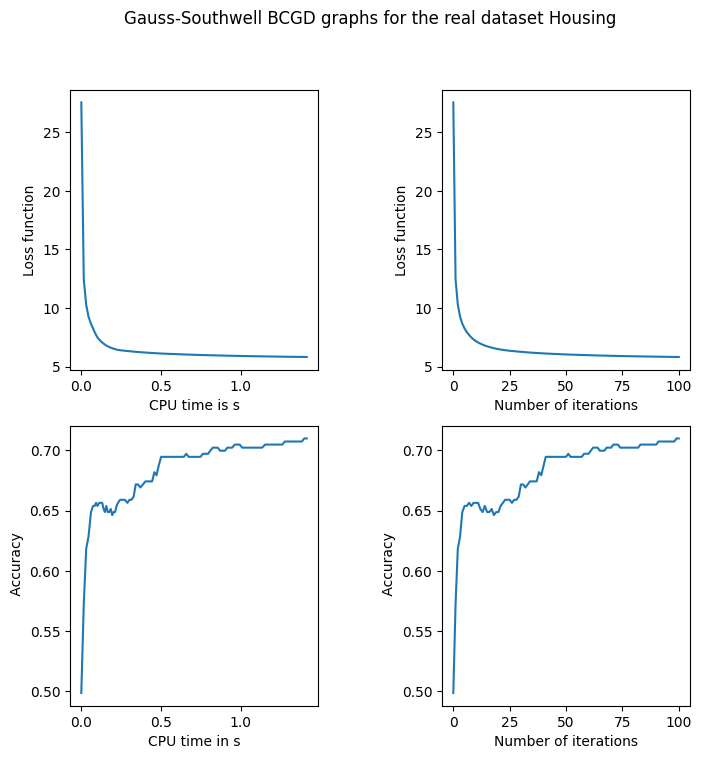

In [318]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(times_gs,f_gs)
axs[0,1].plot(np.arange(0,101),f_gs)
axs[1,0].plot(times_gs,acc_gs)
axs[1,1].plot(np.arange(0,101),acc_gs)

axs[0, 0].set_xlabel('CPU time is s')
axs[0, 0].set_ylabel('Loss function')

axs[0, 1].set_xlabel('Number of iterations')
axs[0, 1].set_ylabel('Loss function')

axs[1, 0].set_xlabel('CPU time in s')
axs[1, 0].set_ylabel(' Accuracy')

axs[1, 1].set_xlabel('Number of iterations')
axs[1, 1].set_ylabel(' Accuracy')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('Gauss-Southwell BCGD graphs for the real dataset Housing')
plt.show()

### Comparison between the three algorithms

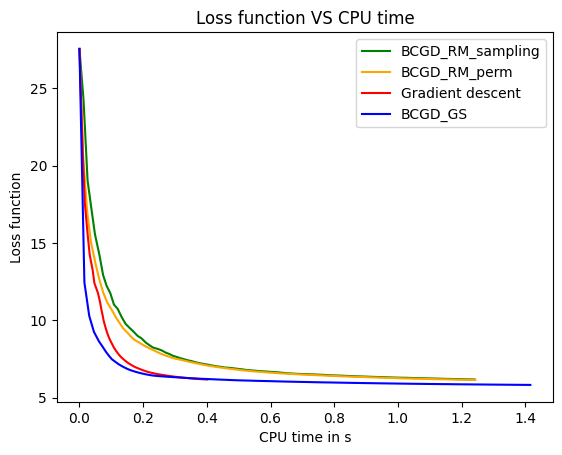

In [319]:
plt.plot(times_r,f_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm, f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_gd,f_gd,label="Gradient descent",color="red")
plt.plot(times_gs,f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel("Loss function")
plt.legend()
plt.show()

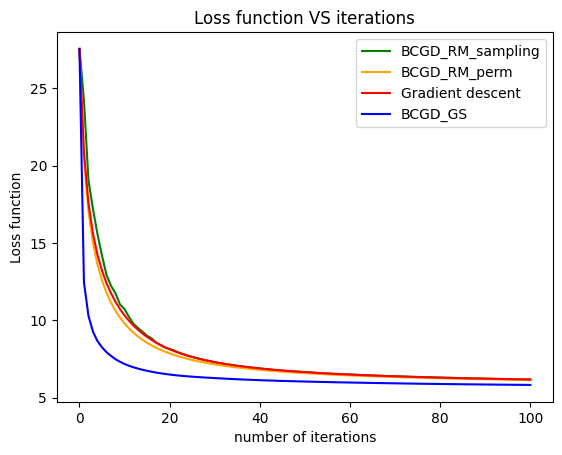

In [320]:
plt.plot(np.arange(0,101),f_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), f_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),f_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),f_gs,label="BCGD_GS",color="blue")
plt.title("Loss function VS iterations")
plt.xlabel("number of iterations")
plt.ylabel("Loss function")
plt.legend()
plt.show()

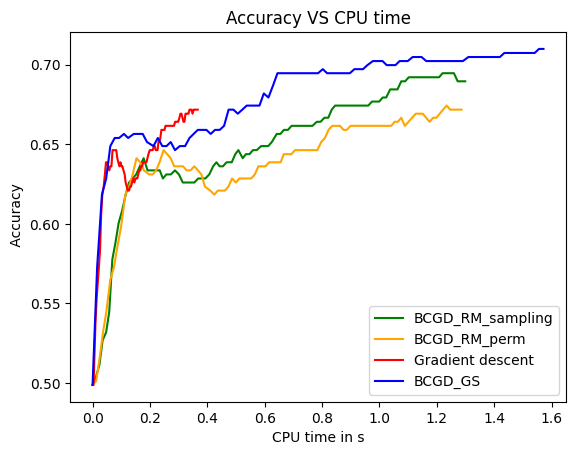

In [321]:
plt.plot(times_r_a,acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(times_perm_a, acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(times_a,acc_gd,label="Gradient descent",color="red")
plt.plot(times_gs_a,acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()

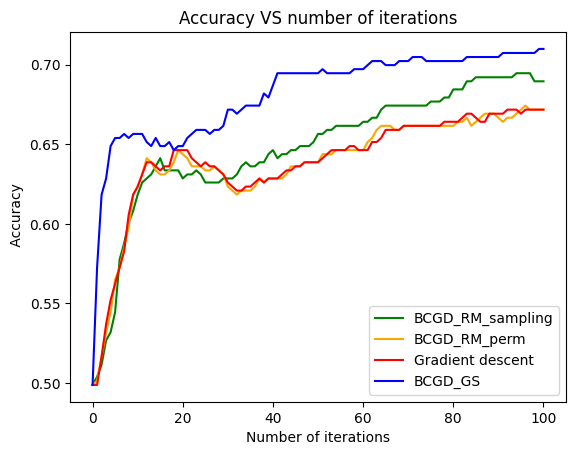

In [322]:
plt.plot(np.arange(0,101),acc_r,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), acc_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,101),acc_gd,label="Gradient descent",color="red")
plt.plot(np.arange(0,101),acc_gs,label="BCGD_GS",color="blue")
plt.title("Accuracy VS number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel(" Accuracy")
plt.legend()
plt.show()